Machine Learning, Innopolis University (Fall semester 2021)


**-Name:** Sohaila Ahmed Rabie Hussein

**-Email:** s.hussein@innopolis.university

# **Human Iris Center Calculation**

## **Import Libraries**

In [ ]:
import numpy as np
import cv2
import glob
from google.colab.patches import cv2_imshow
from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

## **Downloading & Unzipping Dataset**

In [ ]:
!wget https://www2.unavarra.es/gesadj/GI4E/gi4e_database.zip
!sudo apt install unzip 
!unzip gi4e_database.zip


## **Preprocessing**

### Reading Images & Converting to Grayscale

The total number of images: 1236
image size in rgb: (600, 800, 3)


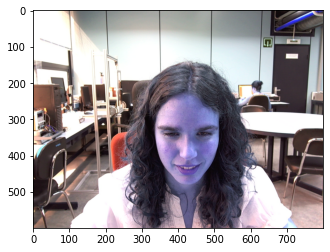

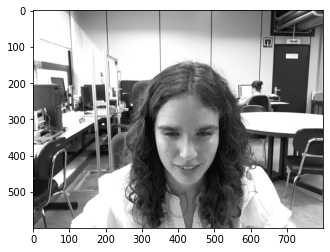

In [ ]:
path = "/content/images/*.png"
images = [cv2.imread(file) for file in sorted(glob.glob(path))] # colored images "rgb"
grayscale_images = [cv2.imread(file,0) for file in sorted(glob.glob(path))] # gray scale images
visualize_images = [cv2.imread(file) for file in sorted(glob.glob(path))]

print("The total number of images:",len(images))
print("image size in rgb:",images[0].shape)

plt.imshow(images[0])
plt.show()
plt.imshow(grayscale_images[0], cmap='gray')


### Reading Image Annotations

In [ ]:
image_labels = np.genfromtxt("/content/labels/image_labels.txt")

# right eye
###########
# external corner
x1 = image_labels[:,1].astype(int)
y1 = image_labels[:,2].astype(int)
# center of iris
x2 = image_labels[:,3].astype(int)
y2 = image_labels[:,4].astype(int)
# internal corner
x3 = image_labels[:,5].astype(int)
y3 = image_labels[:,6].astype(int)

# left eye
###########
# external corner
x4 = image_labels[:,7].astype(int)
y4 = image_labels[:,8].astype(int)
# center of iris
x5 = image_labels[:,9].astype(int)
y5 = image_labels[:,10].astype(int)
# internal corner
x6 = image_labels[:,11].astype(int)
y6 = image_labels[:,12].astype(int)


## Visualizing Eye Corners and Iris Center

A rectangle is used to highlight the eye area in green.
Circles are used to highlight the external and internal eye corners and iris center:
- **iris center:** red
- **external corners:** yellow
- **internal corners:** light blue

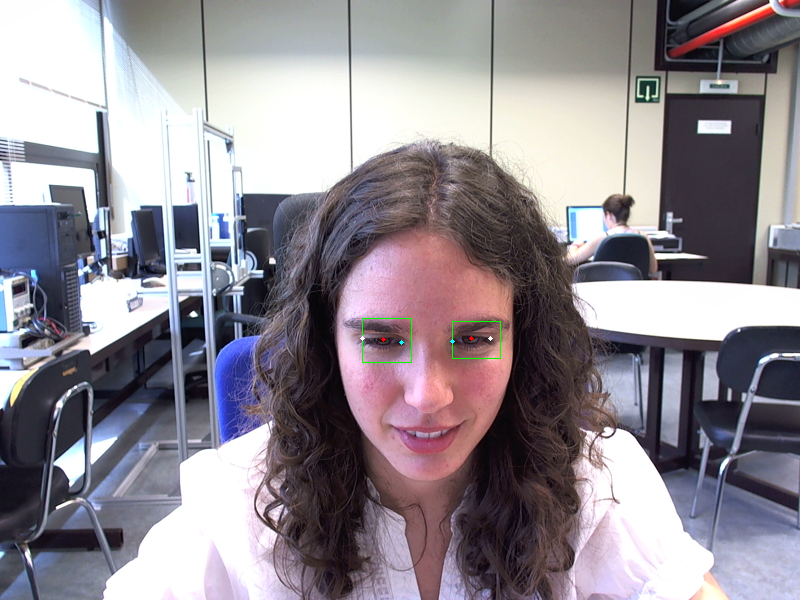

In [ ]:
for i in range(len(visualize_images)):
  right_eye_rect = cv2.rectangle(visualize_images[i], (x1[i]+10, y1[i]+20), (x3[i], y3[i]-20), (0,255,0), 1)
  left_eye_rect = cv2.rectangle(visualize_images[i],(x4[i]+10, y4[i]+20), (x6[i], y6[i]-20), (0,255,0), 1)
  
# cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
  right_eye_external = cv2.circle(visualize_images[i],(x1[i],y1[i]), radius=0, color=(255, 255, 255), thickness=3)
  right_eye_internal = cv2.circle(visualize_images[i],(x3[i],y3[i]), radius=0, color=(255, 255, 0), thickness=3)
  right_eye_center = cv2.circle(visualize_images[i],(x2[i],y2[i]), radius=0, color=(0, 0, 255), thickness=3)

  left_eye_internal = cv2.circle(visualize_images[i],(x4[i],y4[i]), radius=0, color=(255, 255, 0), thickness=3)
  left_eye_external = cv2.circle(visualize_images[i],(x6[i],y6[i]), radius=0, color=(255, 255, 255), thickness=3)
  left_eye_center = cv2.circle(visualize_images[i],(x5[i],y5[i]), radius=0, color=(0, 0, 255), thickness=3)
    
cv2_imshow(visualize_images[0])

### Normalization


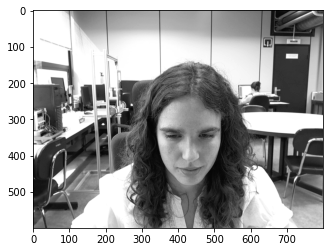

In [ ]:
normalized_images = []
image_size = np.zeros((600,800))
for i in range(len(grayscale_images)):
  normalized_images.append(cv2.normalize(grayscale_images[i], image_size, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)) 

plt.imshow(normalized_images[10],cmap='gray')


### Cropping 

The coordinates of the left eye were used to crop and resize the image.

Image size: (48, 48)


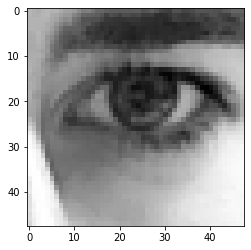

In [ ]:
cropped_images = []
for i in range(len(normalized_images)):
  # the total values of both indices are taken be equal to the image size (48x48)
  cropped_images.append(normalized_images[i][y1[i]-20:y1[i]+28, x3[i]-10:x3[i]+38])  

print("Image size:",cropped_images[50].shape)
plt.imshow(cropped_images[50],'gray')

### Obtaining Y-Labels

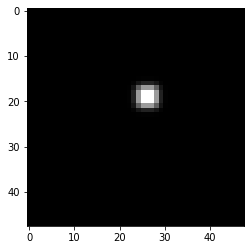

In [ ]:
iris_images = []

for i in range(len(cropped_images)):
  iris_center = np.zeros((48,48))  # creating a black image
  x2_cropped = x2[i] - x3[i] + 10  # originating the x-axis
  y2_cropped = y2[i] - y1[i] + 20  # originating the y-axis
  iris_center[y2_cropped, x2_cropped] = 1  # assigning value [1] to the iris center
  iris_center = gaussian_filter(iris_center, sigma=1)  # gaussian filter is applied (blurring) 
  iris_center = cv2.dilate(iris_center,np.ones((3,3),np.uint8),iterations=1)  # increasing the iris radius range
  iris_images.append(iris_center)  
  
plt.imshow(iris_images[50], cmap='gray')



### Final Dataset 

The final dataset includes the cropped images in the 'X' and the 'Y' consists of the images containing iris centers only.

X shape: (1236, 48, 48), Y shape: (1236, 48, 48)



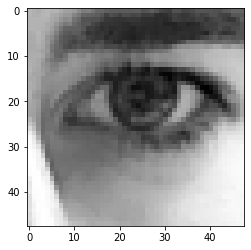

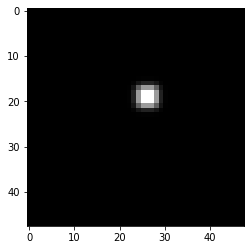

In [ ]:
X = np.array(cropped_images)
Y = np.array(iris_images)

print('X shape: {}, Y shape: {}\n' .format(X.shape, Y.shape))

# Visualizing images from X & Y
plt.imshow(X[50], cmap='gray')
plt.show()
plt.imshow(Y[50], cmap='gray')

### Dataset Splitting

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=123)

print('x_train shape: {}, y_train shape: {}\n' .format(x_train.shape, y_train.shape))
print('x_test shape: {}, y_test shape: {}\n' .format(x_test.shape, y_test.shape))


x_train shape: (1112, 48, 48), y_train shape: (1112, 48, 48)

x_test shape: (124, 48, 48), y_test shape: (124, 48, 48)



## **CNN Model (Pytorch)**

The building of the  CNN model consists of three parts; base betwork, skip connection & auxilary network base on the **paper**: *Accurate Eye Pupil Localization Using Heterogeneous CNN Models*

The dimensions of the $x_{train}$ & $x_{test}$ are converted from **[1112x48x48]** to **[1112x1x48x48]** to include a single channel representing the grayscale image. (same procedure is applied to test data)

In [ ]:
# converts numpy array from [1112*48*48] --> [1112*1*48*48]
x_train = np.expand_dims(x_train, 1) 
x_test = np.expand_dims(x_test, 1) 

# converts numpy array from [124*48*48] --> [124*1*48*48]
y_train = np.expand_dims(y_train, 1) 
y_test = np.expand_dims(y_test, 1) 

print('x_train shape: {}, y_train shape: {}\n' .format(x_train.shape, y_train.shape))
print('x_test shape: {}, y_test shape: {}\n' .format(x_test.shape, y_test.shape))

x_train shape: (1112, 1, 48, 48), y_train shape: (1112, 1, 48, 48)

x_test shape: (124, 1, 48, 48), y_test shape: (124, 1, 48, 48)



In [ ]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layer(1) ##
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1) # conv layer (depth from 1 --> 64), 3x3 kernels
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1) # conv layer (depth from 64 --> 128), 3x3 kernels
        self.pool = nn.MaxPool2d(2, 2)  # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)  # conv layer (depth from 128 --> 256), 3x3 kernels

        ## decoder layer(1) ##
        self.deconv1 = nn.ConvTranspose2d(256, 64, 4, stride=4)  #increases dimension by 4
        self.conv4 = nn.Conv2d(128, 64, 3, padding=1)  # conv layer (depth from 128 --> 64), 3x3 kernels
        self.conv5 = nn.Conv2d(64, 1, 3, padding=1)  # conv layer (depth from 64 --> 1), 3x3 kernels

        ## decoder layer(2) ##
        self.deconv_aux1 = nn.ConvTranspose2d(256, 128, 2, stride=2)  #increases dimension by 2
        self.deconv_aux2 = nn.ConvTranspose2d(128, 64, 2, stride=2)  #increases dimension by 2

    def forward(self, x):
        ## encode (1) ##
        x1 = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x1))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        ## decode (1) ##
        d = F.relu(self.deconv1(x))
        d = torch.cat((x1,d),1)  # concatination
        d = F.relu(self.conv4(d))
        d = torch.tanh(self.conv5(d))  # output layer with tanh 

        ## decode (2) ##
        dd = F.relu(self.deconv_aux1(x))
        dd = F.relu(self.deconv_aux2(dd))
        dd = torch.tanh(self.conv5(dd))  # output layer with tanh 

        return d, dd
    
# initialize the NN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(4, 4))
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv_aux1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (deconv_aux2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
)


## **Training & Testing**

The training model includes the summation of the two output losses of the base and auxilary networks. According to the paper, the auxilary network loss is only consisdered in the train model; hence, the test model consists of the base network loss only.

In [ ]:
# converting train & test data into tensors
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train.astype(np.float32))
x_test_tensor = torch.tensor(x_test)
y_test_tensor = torch.tensor(y_test.astype(np.float32))

batch_size = 32
test_batch_size = 100

# Data loaders
train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor),batch_size=batch_size,shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor),batch_size=test_batch_size,shuffle=False)

# Training Function
def train( model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output1, output2 = model(data)
        loss = criterion(output1, target) + criterion(output2, data)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                                                                     100. * batch_idx / len(train_loader), loss.item()))

# Testing Function            
def test( model, device, test_loader,criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output1, output2 = model(data)
            loss = criterion(output1, target).item()
            test_loss += loss  # sum up batch loss

    test_loss /= len(test_loader.dataset)
    print('\nAverage loss ofTest set: {:.4f}\n'.format(test_loss))
    
    return data, output1

Train Epoch: 1 [0/1112 (0%)]	Loss: 0.193354
Train Epoch: 1 [32/1112 (3%)]	Loss: 0.221687
Train Epoch: 1 [64/1112 (6%)]	Loss: 0.139194
Train Epoch: 1 [96/1112 (9%)]	Loss: 0.101748
Train Epoch: 1 [128/1112 (11%)]	Loss: 0.040126
Train Epoch: 1 [160/1112 (14%)]	Loss: 0.052965
Train Epoch: 1 [192/1112 (17%)]	Loss: 0.061520
Train Epoch: 1 [224/1112 (20%)]	Loss: 0.030382
Train Epoch: 1 [256/1112 (23%)]	Loss: 0.017302
Train Epoch: 1 [288/1112 (26%)]	Loss: 0.021931
Train Epoch: 1 [320/1112 (29%)]	Loss: 0.029882
Train Epoch: 1 [352/1112 (31%)]	Loss: 0.026565
Train Epoch: 1 [384/1112 (34%)]	Loss: 0.027698
Train Epoch: 1 [416/1112 (37%)]	Loss: 0.018617
Train Epoch: 1 [448/1112 (40%)]	Loss: 0.013661
Train Epoch: 1 [480/1112 (43%)]	Loss: 0.014474
Train Epoch: 1 [512/1112 (46%)]	Loss: 0.018874
Train Epoch: 1 [544/1112 (49%)]	Loss: 0.019065
Train Epoch: 1 [576/1112 (51%)]	Loss: 0.013826
Train Epoch: 1 [608/1112 (54%)]	Loss: 0.008877
Train Epoch: 1 [640/1112 (57%)]	Loss: 0.009154
Train Epoch: 1 [672/11

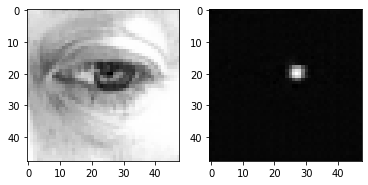

In [ ]:
# Initializing parameters
learning_rate = 0.001
epochs = 50
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, criterion)
    data, output1 = test(model, device, test_loader, criterion)  # extracting the two outputs from the test model

# converting the tensor input image to numpy
input_image_view = data[0].cpu().numpy() # make sure tensor is on cpu
input_image_view = input_image_view.reshape(48,48)

# converting the tensor output image to numpy
output_image_view = output1[0].cpu().numpy() # make sure tensor is on cpu
output_image_view = output_image_view.reshape(48,48)

# plotting input & output image
fig = plt.figure()
fig.add_subplot(1,2, 1)
plt.imshow(input_image_view, cmap='gray')
fig.add_subplot(1,2, 2)
plt.imshow(output_image_view, cmap='gray')
plt.show(block=True)        

After experiencing the possible combinations of optimizers [sgd,adam,adamax,rmsprop], loss functions[mse,mae] and activations [tanh,relu, sigmoid]. It was observed that the best combination of parameters is **adam**, **mse** & **tanh** on outputs.

## **Predictions on ten test images** 

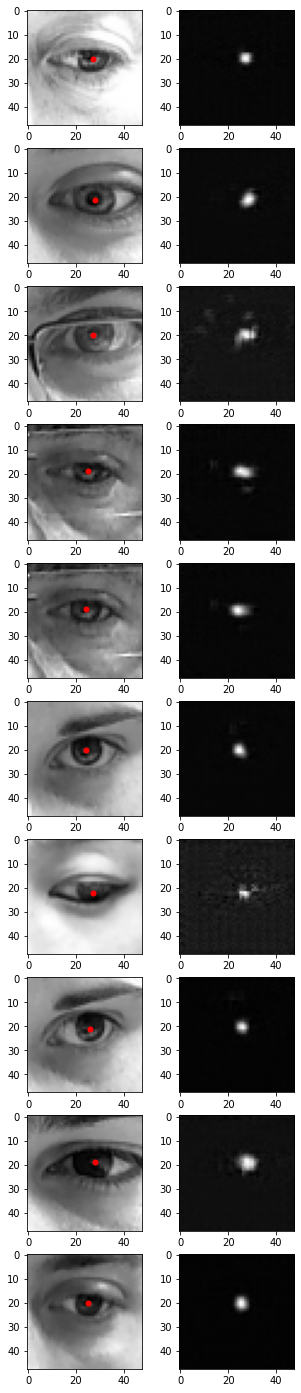

In [ ]:
fig = plt.figure(figsize=[5,25])
for i in range(10):
  # converting the tensor input image to numpy
  input_image_view = data[i].cpu().numpy() # make sure tensor is on cpu
  input_image_view = input_image_view.reshape(48,48)

  # converting the tensor output image to numpy
  output_image_view = output1[i].cpu().numpy() # make sure tensor is on cpu
  output_image_view = output_image_view.reshape(48,48)

  # drawing the iris
  (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(output_image_view)
  fig.add_subplot(10,2,i*2+1)
  plt.imshow(input_image_view,cmap='gray')
  plt.plot(maxLoc[0], maxLoc[1], 'r.', markersize=10.0)
 
  fig.add_subplot(10,2,i*2+2)
  plt.imshow(output_image_view,cmap='gray')

  
